In [2]:
%pip install transformers==4.47.0
%pip install evaluate rouge-score bert-score sacrebleu torch sentencepiece

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartModel,
    BartForConditionalGeneration,
    BartTokenizer,
    ViTModel,
    ViTImageProcessor
)
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from PIL import Image
import pickle
import pandas as pd
from tqdm import tqdm
import evaluate
import math
import os
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from bert_score import score as bert_score_compute
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\amart\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\amart\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
class MuSEDataset(Dataset):
    def __init__(self, tsv_path, objects_pkl_path, descriptions_pkl_path, image_dir):
        super().__init__()
        self.df = pd.read_csv(tsv_path, sep='\t')
        self.df['pid'] = self.df['pid'].astype(str)

        with open(objects_pkl_path, 'rb') as f:
            self.objects_data = pickle.load(f)

        with open(descriptions_pkl_path, 'rb') as f:
            self.descriptions_data = pickle.load(f)

        self.image_dir = image_dir
        self.pids = self.df['pid'].tolist()
        
    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid = self.pids[idx]

        row = self.df[self.df.pid == pid].iloc[0]
        caption = str(row['text']).replace('\'', '')
        target = str(row['target_of_sarcasm'])
        explanation = str(row['explanation'])

        description = self.descriptions_data.get(pid, "")
        
        objects_info = self.objects_data.get(pid, {'classes': []}) # Handle missing PIDs
        object_list = objects_info.get('classes', [])

        image_path = os.path.join(self.image_dir, f"{pid}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image not found for PID {pid} at {image_path}. Returning None.")
            return None

        return {
            "pid": pid,
            "image": image,
            "caption": caption,
            "description": description,
            "objects": object_list,
            "target": target,
            "explanation": explanation
        }

In [4]:
class MuseDataCollator:
    def __init__(
        self,
        bart_tokenizer: BartTokenizer,
        vit_processor: ViTImageProcessor,
        vit_model: nn.Module,
        text_max_len: int = 256,
        explanation_max_len: int = 64
    ):
        self.bart_tokenizer = bart_tokenizer
        self.vit_processor = vit_processor
        self.vit_model = vit_model
        self.text_max_len = text_max_len
        self.explanation_max_len = explanation_max_len
        self.bart_sep_token = self.bart_tokenizer.eos_token

    def __call__(self, batch):
        batch = [item for item in batch if item is not None]
        if not batch:
            return None

        images = [item['image'] for item in batch]
        captions = [item['caption'] for item in batch]
        descriptions = [item['description'] for item in batch]
        objects_list = [item['objects'] for item in batch]
        targets = [item['target'] for item in batch]
        explanations = [item['explanation'] for item in batch]
        
        image_inputs = self.vit_processor(images=images, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
             vit_outputs = self.vit_model(**image_inputs)
             E_v_batch = vit_outputs.last_hidden_state

        T_concat_batch_strings = []
        for c, d, o_list, t in zip(captions, descriptions, objects_list, targets):
            o_string = " ".join(o_list)
            t_knowledge = ' '.join((c, d, o_string))
            t_concat = ' '.join((t_knowledge, self.bart_sep_token, t))
            T_concat_batch_strings.append(t_concat)

        tokenized_T_concat = self.bart_tokenizer(
            T_concat_batch_strings,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.text_max_len
        ).to(DEVICE)

        tokenized_explanations = self.bart_tokenizer(
            explanations,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.explanation_max_len
        ).to(DEVICE)

        labels = tokenized_explanations['input_ids']

        return {
            'E_v': E_v_batch,
            'T_concat_ids': tokenized_T_concat['input_ids'],
            'attention_mask': tokenized_T_concat['attention_mask'],
            'target_explanation_ids': labels
        }

In [5]:
class FeatureExtractorViT(nn.Module):
    def __init__(self, vit_model_name="google/vit-base-patch16-224-in21k"):
        super().__init__()
        self.vit_processor = ViTImageProcessor.from_pretrained(vit_model_name)
        self.vit_model = ViTModel.from_pretrained(vit_model_name)
        self.embedding_dim = self.vit_model.config.hidden_size

    def forward(self, image):
        try:
            processed_inputs = self.vit_processor(images=image, return_tensors="pt")
            processed_inputs = processed_inputs.to(self.vit_model.device)
        except Exception as e:
            print(f"Error processing image with ViTProcessor: {e}")
            return None

        with torch.no_grad():
            outputs = self.vit_model(**processed_inputs)

        E_v = outputs.last_hidden_state
        return E_v

In [6]:
class BART_SF(nn.Module):
    def __init__(
        self,
        bart_model_name,
        bart_tokenizer,
        vit_feature_extractor=FeatureExtractorViT(),
        vit_seq_len=197,
        text_seq_len=256
    ):
        super().__init__()

        self.bart_tokenizer = bart_tokenizer
        self.bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)
        self.text_embedding_dim = self.bart_model.config.d_model

        self.vit_feature_extractor = vit_feature_extractor
        self.image_embedding_dim = self.vit_feature_extractor.embedding_dim

        if self.text_embedding_dim != self.image_embedding_dim:
            self.image_feature_proj_dim = nn.Linear(self.image_embedding_dim, self.text_embedding_dim)
            self.D_f = self.text_embedding_dim
        else:
            self.image_feature_proj_dim = nn.Identity()
            self.D_f = self.text_embedding_dim
            
        self.vit_seq_len = vit_seq_len
        self.text_seq_len = text_seq_len
        if self.vit_seq_len != self.text_seq_len:
            self.image_seq_proj_len = nn.Linear(self.vit_seq_len, self.text_seq_len)
        else:
            print("ViT and Text sequence lengths match. No sequence projection layer needed.")
            self.image_seq_proj_len = None

        self.query_v = nn.Linear(self.D_f, self.D_f)
        self.key_v = nn.Linear(self.D_f, self.D_f)
        self.value_v = nn.Linear(self.D_f, self.D_f)
        
        self.query_t = nn.Linear(self.D_f, self.D_f)
        self.key_t = nn.Linear(self.D_f, self.D_f)
        self.value_t = nn.Linear(self.D_f, self.D_f)
        
        self.gate_v_layer = nn.Linear(self.D_f, self.D_f)
        self.gate_t_layer = nn.Linear(self.D_f, self.D_f)
        
        self.alpha1 = nn.Parameter(torch.tensor(1.0))
        self.alpha2 = nn.Parameter(torch.tensor(1.0))
        self.beta1 = nn.Parameter(torch.tensor(1.0))
        self.beta2 = nn.Parameter(torch.tensor(1.0))

    def _attention(self, Q, K, V, d_f):
        A = torch.matmul(Q, K.transpose(-1, -2))
        A = torch.softmax(A / math.sqrt(d_f), dim=-1)
        A = torch.matmul(A, V)
        return A
        
    def forward(self, E_v, T_concat_text, attention_mask, target_explanation_ids=None, generate=False):
        E_v = self.image_feature_proj_dim(E_v)

        encoder_outputs = self.bart_model.model.encoder(
            input_ids=T_concat_text,
            attention_mask=attention_mask
        )
        E_t = encoder_outputs.last_hidden_state
        
        if E_v.shape[1] != E_t.shape[1]:
            if self.image_seq_proj_len is not None:
                E_v_proj = self.image_seq_proj_len(E_v.transpose(1, 2))
                E_v = E_v_proj.transpose(1, 2)
            else:
                print(f"Error: Sequence length mismatch ({E_v.shape[1]} vs {E_t.shape[1]}) but no projection layer defined.")
                raise ValueError("Sequence lengths differ but no projection layer available.")

        Q_v, K_v, V_v = self.query_v(E_v), self.key_v(E_v), self.value_v(E_v)
        A_v = self._attention(Q_v, K_v, V_v, self.D_f)
        
        Q_t, K_t, V_t = self.query_t(E_t), self.key_t(E_t), self.value_t(E_t)
        A_t = self._attention(Q_t, K_t, V_t, self.D_f)

        F_vt = A_t * E_v
        F_tv = A_v * E_t

        G_v = torch.sigmoid(self.gate_v_layer(E_v))
        G_t = torch.sigmoid(self.gate_t_layer(E_t))

        F1 = (G_v * F_tv) + ((1 - G_v) * F_vt)
        F2 = (G_t * F_tv) + ((1 - G_t) * F_vt)
        F_v = (G_v * E_v) + ((1 - G_v) * F_tv)
        F_t = (G_t * E_t) + ((1 - G_t) * F_vt)

        F_SF = self.alpha1 * F1 + self.alpha2 * F2 + self.beta1 * F_v + self.beta2 * F_t

        if generate:
            encoder_output_object = BaseModelOutputWithPastAndCrossAttentions(
                last_hidden_state=F_SF
            )
            generated_ids = self.bart_model.generate(
                 encoder_outputs=encoder_output_object,
                 attention_mask=attention_mask,
                 num_beams=4,
                 early_stopping=True
            )
            return generated_ids
        else:
            labels = None
            if target_explanation_ids is not None:
                 labels = target_explanation_ids.clone()
                 labels[labels == self.bart_tokenizer.pad_token_id] = -100

            outputs = self.bart_model(
                 encoder_outputs=(F_SF,),
                 attention_mask=attention_mask,
                 labels=labels,
                 return_dict=True
            )
            return outputs

In [7]:
def train_epoch(
    model: BART_SF,
    data_loader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer
):
    model.train()
    total_loss = 0

    progress_bar = tqdm(data_loader, desc="Training Epoch", leave=False)

    for batch in progress_bar:
        E_v_batch = batch['E_v'].to(DEVICE)
        T_concat_ids_batch = batch['T_concat_ids'].to(DEVICE)
        attention_mask_batch = batch['attention_mask'].to(DEVICE)
        target_ids_batch = batch['target_explanation_ids'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(
            E_v=E_v_batch,
            T_concat_text=T_concat_ids_batch,
            attention_mask=attention_mask_batch,
            target_explanation_ids=target_ids_batch,
            generate=False
        )

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")
    return avg_loss

In [8]:
def evaluate_model(
    model: nn.Module, # Or specific class BART_SF
    data_loader: torch.utils.data.DataLoader,
    tokenizer: BartTokenizer, # Use specific tokenizer class if known
    max_gen_length: int = 64,
    num_samples_to_print: int = 5 # Set > 0 to print samples
):
    """
    Evaluates the model using ROUGE(1,2,L), BLEU(1-4 via Sacre), METEOR, BERTScore,
    and prints sample reference/generated pairs.

    Args:
        model: The model instance (e.g., BART_SF).
        data_loader: DataLoader for the evaluation set.
        DEVICE: The DEVICE to run evaluation on ('cuda' or 'cpu').
        tokenizer: The tokenizer used for decoding.
        max_gen_length: Max length for generated sequences (Note: passed to generate if needed).
        num_samples_to_print: How many reference/generated pairs to print.

    Returns:
        dict: A dictionary containing the calculated metric scores.
              Returns None if evaluation fails.
    """
    model.eval()
    all_generated_texts = []
    all_reference_texts = []
    samples_printed_count = 0 # Counter for printed samples
    metrics_loaded = True

    # --- Initialize Metrics ---
    try:
        rouge_metric = evaluate.load('rouge')
        # Using 'sacrebleu' for potentially easier access to BLEU-1..4 scores
        bleu_metric = evaluate.load('sacrebleu')
        meteor_metric = evaluate.load('meteor') # Requires NLTK + data
        bertscore_metric = evaluate.load('bertscore')
        print("Metrics (ROUGE, BLEU(Sacre), METEOR, BERTScore) loaded via evaluate.")
    except Exception as e:
        print(f"Error loading one or more metrics via evaluate: {e}")
        print("Ensure 'evaluate', 'rouge-score', 'sacrebleu', 'nltk', 'bert-score' are installed and NLTK data is available.")
        metrics_loaded = False
        return None

    # --- Check DataLoader Length ---
    try:
        dataloader_len = len(data_loader)
        if dataloader_len == 0:
             print("Error: Evaluation DataLoader is empty. Skipping evaluation.")
             return None
        print(f"Evaluation DataLoader contains {dataloader_len} batches.")
    except TypeError:
         print("Warning: Could not determine DataLoader length beforehand.")
         dataloader_len = "Unknown"

    print("Starting evaluation loop...")
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for i, batch in enumerate(progress_bar):
            if batch is None: continue
            try:
                # Unpack batch and move to DEVICE
                E_v_batch = batch['E_v'].to(DEVICE)
                T_concat_ids_batch = batch['T_concat_ids'].to(DEVICE)
                attention_mask_batch = batch['attention_mask'].to(DEVICE)
                target_ids_batch = batch['target_explanation_ids'].to(DEVICE)

                # Generate
                generated_ids = model(E_v=E_v_batch, T_concat_text=T_concat_ids_batch,
                                      attention_mask=attention_mask_batch, generate=True)

                # Decode
                generated_batch_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                ref_ids_clone = target_ids_batch.clone()
                ref_ids_clone[ref_ids_clone == -100] = tokenizer.pad_token_id
                reference_batch_texts = tokenizer.batch_decode(ref_ids_clone, skip_special_tokens=True)

                # --- Print Sample Outputs --- ## <<< ADDED BACK ##
                if samples_printed_count < num_samples_to_print:
                    num_to_print_this_batch = min(num_samples_to_print - samples_printed_count, len(generated_batch_texts))
                    if num_to_print_this_batch > 0:
                        print(f"\n--- Sample Outputs (Batch {i+1}) ---")
                        for idx in range(num_to_print_this_batch):
                            print(f"\n[Sample {samples_printed_count + 1}]")
                            print(f"  Reference : {reference_batch_texts[idx]}")
                            print(f"  Generated : {generated_batch_texts[idx]}")
                            samples_printed_count += 1
                        if num_to_print_this_batch > 0:
                             print("-" * 30)
                # --- End Sample Printing --- ## <<< ADDED BACK ##

                # --- Accumulate data for metrics ---
                # Wrap references for sacrebleu: [[ref1], [ref2], ...]
                references_for_bleu = [[ref] for ref in reference_batch_texts]

                # Check for empty strings before adding, some metrics fail on them
                valid_preds = [p for p, r in zip(generated_batch_texts, reference_batch_texts) if p and r]
                valid_refs = [r for p, r in zip(generated_batch_texts, reference_batch_texts) if p and r]
                valid_refs_for_bleu = [[r] for p, r in zip(generated_batch_texts, reference_batch_texts) if p and r]

                if valid_preds: # Only add if there are valid pairs in the batch
                    rouge_metric.add_batch(predictions=valid_preds, references=valid_refs)
                    bleu_metric.add_batch(predictions=valid_preds, references=valid_refs_for_bleu)
                    meteor_metric.add_batch(predictions=valid_preds, references=valid_refs)

                    # Collect all for BERTScore (it might handle empties, but best to be consistent)
                    all_generated_texts.extend(valid_preds)
                    all_reference_texts.extend(valid_refs)

            except Exception as e:
                print(f"Error processing batch {i+1}: {e}. Skipping.")
                # import traceback # Uncomment for debug
                # traceback.print_exc()
                continue

    # --- Final Metric Computations ---
    print("\nCalculating final metrics...")
    if not all_generated_texts: # Check if any valid data was processed
        print("Error: No valid texts were generated/collected. Cannot compute metrics.")
        return None

    results = {}
    computed_metrics = {}
    try:
        print("Computing ROUGE...")
        computed_metrics['rouge'] = rouge_metric.compute()
        print("Computing BLEU (Sacre)...")
        computed_metrics['bleu'] = bleu_metric.compute()
        print("Computing METEOR...")
        # !! This might fail again if NLTK/WordNet issue persists !!
        computed_metrics['meteor'] = meteor_metric.compute()
        print("Computing BERTScore...")
        computed_metrics['bertscore'] = bertscore_metric.compute(
            predictions=all_generated_texts, references=all_reference_texts, lang="en",
            # model_type="microsoft/deberta-xlarge-mnli" # Specify if needed
            device=str(DEVICE)
        )

        # --- Format Results ---
        # ROUGE
        results['rouge1'] = computed_metrics['rouge'].get('rouge1', 0.0) # Use .get for safety
        results['rouge2'] = computed_metrics['rouge'].get('rouge2', 0.0)
        results['rougeL'] = computed_metrics['rouge'].get('rougeL', 0.0)

        # BLEU (from Sacrebleu output)
        results['bleu'] = computed_metrics['bleu'].get('score', 0.0) / 100.0
        precisions = computed_metrics['bleu'].get('precisions', [0.0] * 4)
        for i, prec in enumerate(precisions[:4]): # Ensure we only take up to 4
             results[f'bleu-{i+1}'] = prec / 100.0

        # METEOR
        results['meteor'] = computed_metrics['meteor'].get('meteor', 0.0)

        # BERTScore
        results['bertscore_precision'] = np.mean(computed_metrics['bertscore'].get('precision', [0.0]))
        results['bertscore_recall'] = np.mean(computed_metrics['bertscore'].get('recall', [0.0]))
        results['bertscore_f1'] = np.mean(computed_metrics['bertscore'].get('f1', [0.0]))


        print("\nEvaluation Metrics Calculated:")
        # (Metric printing logic remains the same)
        # ...
        return results

    except ImportError as e:
         print(f"\nERROR calculating metrics: {e}")
         print("This often indicates a missing dependency (like NLTK data for METEOR).")
         return None
    except Exception as e:
        print(f"\nError calculating final metrics: {e}")
        # import traceback
        # traceback.print_exc()
        return None

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]


--- Starting Training ---

--- Epoch 1/10 ---


Average Training Loss: 1.8484


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6174682343799991, 'rouge1_recall': 0.5083284061357223, 'rouge1_fmeasure': 0.5379979686215518, 'rouge2_precision': 0.4355112749062329, 'rouge2_recall': 0.3497356043181718, 'rouge2_fmeasure': 0.3736501266790426, 'rougeL_precision': 0.5831083799487161, 'rougeL_recall': 0.4800769388053154, 'rougeL_fmeasure': 0.5081060896549834, 'bleu': 0.30609142781222914, 'bertscore_precision': 0.9225200414657593, 'bertscore_recall': 0.9103135466575623, 'bertscore_f1': 0.9161460399627686}
Epoch 1 Validation Metrics:
  rouge1_precision: 0.6175
  rouge1_recall: 0.5083
  rouge1_fmeasure: 0.5380
  rouge2_precision: 0.4355
  rouge2_recall: 0.3497
  rouge2_fmeasure: 0.3737
  rougeL_precision: 0.5831
  rougeL_recall: 0.4801
  rougeL_fmeasure: 0.5081
  bleu: 0.3061
  bertscore_precision: 0.9225
  bertscore_recall: 0.9103
  bertscore_f1: 0.9161
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_1/model.pkl
Saving tokenizer to: /kaggle/working/m

Average Training Loss: 1.3214


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6247621071738719, 'rouge1_recall': 0.5227589435414789, 'rouge1_fmeasure': 0.5514960183593984, 'rouge2_precision': 0.45023959420598075, 'rouge2_recall': 0.371105417792889, 'rouge2_fmeasure': 0.3941704933481009, 'rougeL_precision': 0.5889351199687334, 'rougeL_recall': 0.49187262455479175, 'rougeL_fmeasure': 0.5198524342165057, 'bleu': 0.32369477132635693, 'bertscore_precision': 0.9249452352523804, 'bertscore_recall': 0.9132773280143738, 'bertscore_f1': 0.9188628196716309}
Epoch 2 Validation Metrics:
  rouge1_precision: 0.6248
  rouge1_recall: 0.5228
  rouge1_fmeasure: 0.5515
  rouge2_precision: 0.4502
  rouge2_recall: 0.3711
  rouge2_fmeasure: 0.3942
  rougeL_precision: 0.5889
  rougeL_recall: 0.4919
  rougeL_fmeasure: 0.5199
  bleu: 0.3237
  bertscore_precision: 0.9249
  bertscore_recall: 0.9133
  bertscore_f1: 0.9189
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_2/model.pkl
Saving tokenizer to: /kaggle/working/

Average Training Loss: 0.9704


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6255232447291271, 'rouge1_recall': 0.5295100404371137, 'rouge1_fmeasure': 0.5558628321666712, 'rouge2_precision': 0.4445375921930544, 'rouge2_recall': 0.37252222886396996, 'rouge2_fmeasure': 0.391755402705915, 'rougeL_precision': 0.591180281436584, 'rougeL_recall': 0.5021979835439279, 'rougeL_fmeasure': 0.526314888820969, 'bleu': 0.32561651074436193, 'bertscore_precision': 0.9252222776412964, 'bertscore_recall': 0.9159884452819824, 'bertscore_f1': 0.920348584651947}
Epoch 3 Validation Metrics:
  rouge1_precision: 0.6255
  rouge1_recall: 0.5295
  rouge1_fmeasure: 0.5559
  rouge2_precision: 0.4445
  rouge2_recall: 0.3725
  rouge2_fmeasure: 0.3918
  rougeL_precision: 0.5912
  rougeL_recall: 0.5022
  rougeL_fmeasure: 0.5263
  bleu: 0.3256
  bertscore_precision: 0.9252
  bertscore_recall: 0.9160
  bertscore_f1: 0.9203
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_3/model.pkl
Saving tokenizer to: /kaggle/working/mode

Average Training Loss: 0.7336


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6164396714396714, 'rouge1_recall': 0.519779039688791, 'rouge1_fmeasure': 0.5483260731642086, 'rouge2_precision': 0.4369193271714281, 'rouge2_recall': 0.36195212370101876, 'rouge2_fmeasure': 0.38439561866499, 'rougeL_precision': 0.58123284978327, 'rougeL_recall': 0.48949466979296924, 'rougeL_fmeasure': 0.5168683165777449, 'bleu': 0.31631220426130047, 'bertscore_precision': 0.9239041805267334, 'bertscore_recall': 0.9132238626480103, 'bertscore_f1': 0.918347954750061}
Epoch 4 Validation Metrics:
  rouge1_precision: 0.6164
  rouge1_recall: 0.5198
  rouge1_fmeasure: 0.5483
  rouge2_precision: 0.4369
  rouge2_recall: 0.3620
  rouge2_fmeasure: 0.3844
  rougeL_precision: 0.5812
  rougeL_recall: 0.4895
  rougeL_fmeasure: 0.5169
  bleu: 0.3163
  bertscore_precision: 0.9239
  bertscore_recall: 0.9132
  bertscore_f1: 0.9183
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_4/model.pkl
Saving tokenizer to: /kaggle/working/model

Average Training Loss: 0.5532


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6374961275885646, 'rouge1_recall': 0.54055835284725, 'rouge1_fmeasure': 0.5688508778901757, 'rouge2_precision': 0.45362189817652004, 'rouge2_recall': 0.3798418158816994, 'rouge2_fmeasure': 0.4002821554616852, 'rougeL_precision': 0.6025915918815079, 'rougeL_recall': 0.5103353276342488, 'rougeL_fmeasure': 0.5373808264014763, 'bleu': 0.32016752289260914, 'bertscore_precision': 0.9261388182640076, 'bertscore_recall': 0.9163761734962463, 'bertscore_f1': 0.9210516214370728}
Epoch 5 Validation Metrics:
  rouge1_precision: 0.6375
  rouge1_recall: 0.5406
  rouge1_fmeasure: 0.5689
  rouge2_precision: 0.4536
  rouge2_recall: 0.3798
  rouge2_fmeasure: 0.4003
  rougeL_precision: 0.6026
  rougeL_recall: 0.5103
  rougeL_fmeasure: 0.5374
  bleu: 0.3202
  bertscore_precision: 0.9261
  bertscore_recall: 0.9164
  bertscore_f1: 0.9211
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_5/model.pkl
Saving tokenizer to: /kaggle/working/mo

Average Training Loss: 0.4123


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.5921042664151908, 'rouge1_recall': 0.5229908144729495, 'rouge1_fmeasure': 0.5387949831499098, 'rouge2_precision': 0.40788839731696874, 'rouge2_recall': 0.35300754178177873, 'rouge2_fmeasure': 0.3670157453812976, 'rougeL_precision': 0.5533842889137007, 'rougeL_recall': 0.4868178291936702, 'rougeL_fmeasure': 0.5028045655502881, 'bleu': 0.3012895924754538, 'bertscore_precision': 0.920824408531189, 'bertscore_recall': 0.9144759774208069, 'bertscore_f1': 0.9174407124519348}
Epoch 6 Validation Metrics:
  rouge1_precision: 0.5921
  rouge1_recall: 0.5230
  rouge1_fmeasure: 0.5388
  rouge2_precision: 0.4079
  rouge2_recall: 0.3530
  rouge2_fmeasure: 0.3670
  rougeL_precision: 0.5534
  rougeL_recall: 0.4868
  rougeL_fmeasure: 0.5028
  bleu: 0.3013
  bertscore_precision: 0.9208
  bertscore_recall: 0.9145
  bertscore_f1: 0.9174
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_6/model.pkl
Saving tokenizer to: /kaggle/working/m

Average Training Loss: 0.3072


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6153362076765438, 'rouge1_recall': 0.5538350750227122, 'rouge1_fmeasure': 0.5645293503147827, 'rouge2_precision': 0.45025453864529497, 'rouge2_recall': 0.3987495641842231, 'rouge2_fmeasure': 0.40831592715304216, 'rougeL_precision': 0.5846934340169634, 'rougeL_recall': 0.5239810145324132, 'rougeL_fmeasure': 0.5353093713173054, 'bleu': 0.3234946297198962, 'bertscore_precision': 0.9219918251037598, 'bertscore_recall': 0.9173619151115417, 'bertscore_f1': 0.9194568991661072}
Epoch 7 Validation Metrics:
  rouge1_precision: 0.6153
  rouge1_recall: 0.5538
  rouge1_fmeasure: 0.5645
  rouge2_precision: 0.4503
  rouge2_recall: 0.3987
  rouge2_fmeasure: 0.4083
  rougeL_precision: 0.5847
  rougeL_recall: 0.5240
  rougeL_fmeasure: 0.5353
  bleu: 0.3235
  bertscore_precision: 0.9220
  bertscore_recall: 0.9174
  bertscore_f1: 0.9195
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_7/model.pkl
Saving tokenizer to: /kaggle/working/

Average Training Loss: 0.2316


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.622826909784893, 'rouge1_recall': 0.5291146423229871, 'rouge1_fmeasure': 0.5528557840389691, 'rouge2_precision': 0.43945861887878696, 'rouge2_recall': 0.3744228759993344, 'rouge2_fmeasure': 0.39004281226037735, 'rougeL_precision': 0.5867173703980425, 'rougeL_recall': 0.5022075399387016, 'rougeL_fmeasure': 0.5234083178206667, 'bleu': 0.3239130600526213, 'bertscore_precision': 0.9244793057441711, 'bertscore_recall': 0.9151553511619568, 'bertscore_f1': 0.9195706844329834}
Epoch 8 Validation Metrics:
  rouge1_precision: 0.6228
  rouge1_recall: 0.5291
  rouge1_fmeasure: 0.5529
  rouge2_precision: 0.4395
  rouge2_recall: 0.3744
  rouge2_fmeasure: 0.3900
  rougeL_precision: 0.5867
  rougeL_recall: 0.5022
  rougeL_fmeasure: 0.5234
  bleu: 0.3239
  bertscore_precision: 0.9245
  bertscore_recall: 0.9152
  bertscore_f1: 0.9196
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_8/model.pkl
Saving tokenizer to: /kaggle/working/m

Average Training Loss: 0.1729


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6091538274983653, 'rouge1_recall': 0.5383019574211229, 'rouge1_fmeasure': 0.554771974107218, 'rouge2_precision': 0.43590832650076355, 'rouge2_recall': 0.37783479424473343, 'rouge2_fmeasure': 0.3919702041932421, 'rougeL_precision': 0.5727473730751041, 'rougeL_recall': 0.5033885242173212, 'rougeL_fmeasure': 0.5201948060554195, 'bleu': 0.31671566897442527, 'bertscore_precision': 0.9218881726264954, 'bertscore_recall': 0.914803147315979, 'bertscore_f1': 0.9181503057479858}
Epoch 9 Validation Metrics:
  rouge1_precision: 0.6092
  rouge1_recall: 0.5383
  rouge1_fmeasure: 0.5548
  rouge2_precision: 0.4359
  rouge2_recall: 0.3778
  rouge2_fmeasure: 0.3920
  rougeL_precision: 0.5727
  rougeL_recall: 0.5034
  rougeL_fmeasure: 0.5202
  bleu: 0.3167
  bertscore_precision: 0.9219
  bertscore_recall: 0.9148
  bertscore_f1: 0.9182
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_9/model.pkl
Saving tokenizer to: /kaggle/working/m

Average Training Loss: 0.1401


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics Calculated:
{'rouge1_precision': 0.6164762632325658, 'rouge1_recall': 0.5182278820641605, 'rouge1_fmeasure': 0.5462481215951914, 'rouge2_precision': 0.4351308294879724, 'rouge2_recall': 0.3594346647054233, 'rouge2_fmeasure': 0.3807501499557381, 'rougeL_precision': 0.5827098298526869, 'rougeL_recall': 0.4886256633460146, 'rougeL_fmeasure': 0.5162027500259964, 'bleu': 0.308688895738145, 'bertscore_precision': 0.9240379333496094, 'bertscore_recall': 0.9142255783081055, 'bertscore_f1': 0.9189184308052063}
Epoch 10 Validation Metrics:
  rouge1_precision: 0.6165
  rouge1_recall: 0.5182
  rouge1_fmeasure: 0.5462
  rouge2_precision: 0.4351
  rouge2_recall: 0.3594
  rouge2_fmeasure: 0.3808
  rougeL_precision: 0.5827
  rougeL_recall: 0.4886
  rougeL_fmeasure: 0.5162
  bleu: 0.3087
  bertscore_precision: 0.9240
  bertscore_recall: 0.9142
  bertscore_f1: 0.9189
Saving model state dict to: /kaggle/working/model_checkpoints/epoch_10/model.pkl
Saving tokenizer to: /kaggle/working/m

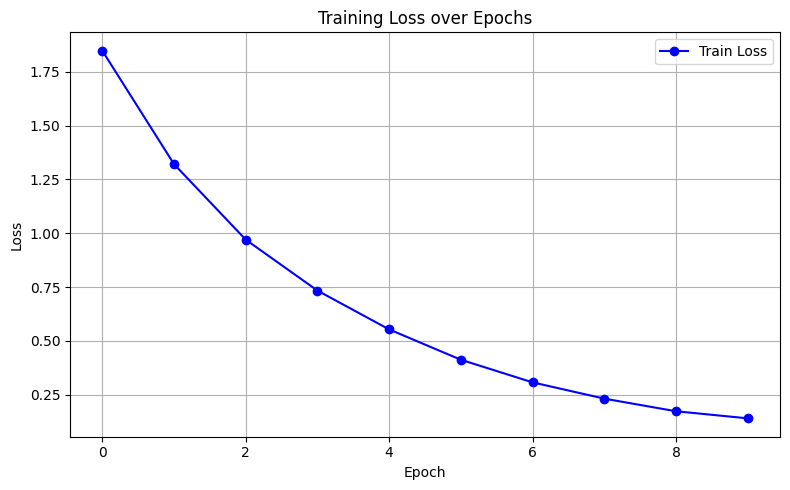

In [8]:
BASE_DATA_PATH = '/kaggle/input/muse-dataset/'
TRAIN_TSV = os.path.join(BASE_DATA_PATH, 'train_df.tsv')
VAL_TSV = os.path.join(BASE_DATA_PATH, 'val_df.tsv')
TRAIN_OBJECTS_PKL = os.path.join(BASE_DATA_PATH, 'O_train.pkl')
VAL_OBJECTS_PKL = os.path.join(BASE_DATA_PATH, 'O_val.pkl')
TRAIN_DESCRIPTIONS_PKL = os.path.join(BASE_DATA_PATH, 'D_train.pkl')
VAL_DESCRIPTIONS_PKL = os.path.join(BASE_DATA_PATH, 'D_val.pkl')
IMAGE_DIR = os.path.join(BASE_DATA_PATH, 'images/')
OUTPUT_DIR = '/kaggle/working/model_checkpoints/'

BART_MODEL_NAME = "facebook/bart-base"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"

VIT_SEQ_LEN = 197
TEXT_SEQ_LEN = 256
EXP_MAX_LEN = 64

LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 16

os.makedirs(OUTPUT_DIR, exist_ok=True)

bart_tokenizer = BartTokenizer.from_pretrained(BART_MODEL_NAME)
vit_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)

vit_feature_extractor = FeatureExtractorViT(VIT_MODEL_NAME).to(DEVICE)
vit_feature_extractor.eval()

try:
    train_dataset = MuSEDataset(
        tsv_path=TRAIN_TSV,
        objects_pkl_path=TRAIN_OBJECTS_PKL,
        descriptions_pkl_path=TRAIN_DESCRIPTIONS_PKL,
        image_dir=IMAGE_DIR
    )
    val_dataset = MuSEDataset(
        tsv_path=VAL_TSV,
        objects_pkl_path=VAL_OBJECTS_PKL,
        descriptions_pkl_path=VAL_DESCRIPTIONS_PKL,
        image_dir=IMAGE_DIR
    )
except FileNotFoundError as e:
    print(f"Error loading dataset files: {e}")
    print("Please ensure all dataset paths are correct.")
    exit()
    
data_collator = MuseDataCollator(
    bart_tokenizer=bart_tokenizer,
    vit_processor=vit_processor,
    vit_model=vit_feature_extractor.vit_model, # Pass the actual ViT model part
    text_max_len=TEXT_SEQ_LEN,
    explanation_max_len=EXP_MAX_LEN,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=True,
    pin_memory=True if DEVICE == 'cuda' else False # Improve GPU transfer speed
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=False,
    pin_memory=True if DEVICE == 'cuda' else False
)

model = BART_SF(
    bart_model_name=BART_MODEL_NAME,
    bart_tokenizer=bart_tokenizer,
    vit_feature_extractor=vit_feature_extractor,
    vit_seq_len=VIT_SEQ_LEN,
    text_seq_len=TEXT_SEQ_LEN
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_losses = []

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    avg_train_loss = train_epoch(model, train_dataloader, optimizer)
    train_losses.append(avg_train_loss)

    val_metrics = evaluate_model(model, val_dataloader, bart_tokenizer, EXP_MAX_LEN)
    if val_metrics:
        print(f"Epoch {epoch+1} Validation Metrics:")
        for metric, score in val_metrics.items():
             if isinstance(score, dict):
                 print(f"  {metric}:")
                 for sub_metric, sub_score in score.items():
                     print(f"    {sub_metric}: {sub_score:.4f}")
             else:
                 print(f"  {metric}: {score:.4f}")
    else:
        print("Validation evaluation failed.")

    epoch_checkpoint_dir = os.path.join(OUTPUT_DIR, f"epoch_{epoch+1}")
    os.makedirs(epoch_checkpoint_dir, exist_ok=True)

    model_save_path = os.path.join(epoch_checkpoint_dir, "model.pkl")
    print(f"Saving model state dict to: {model_save_path}")
    torch.save(model, model_save_path)

    print(f"Saving tokenizer to: {epoch_checkpoint_dir}")
    model.bart_tokenizer.save_pretrained(epoch_checkpoint_dir)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
BASE_DATA_PATH = './'
TEST_TSV = os.path.join(BASE_DATA_PATH, 'test_df.tsv')
TEST_OBJECTS_PKL = os.path.join(BASE_DATA_PATH, 'O_test.pkl')
TEST_DESCRIPTIONS_PKL = os.path.join(BASE_DATA_PATH, 'D_test.pkl')
IMAGE_DIR = os.path.join(BASE_DATA_PATH, 'images/')

CHECKPOINT_TO_LOAD_DIR = './epoch_8'

BART_MODEL_NAME = "facebook/bart-base"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"

VIT_SEQ_LEN = 197
TEXT_SEQ_LEN = 256
EXP_MAX_LEN = 64

BATCH_SIZE = 16

if not CHECKPOINT_TO_LOAD_DIR or not os.path.isdir(CHECKPOINT_TO_LOAD_DIR):
    print(f"Error: Specified checkpoint directory not found or not set: {CHECKPOINT_TO_LOAD_DIR}")
    exit()

model_path = os.path.join(CHECKPOINT_TO_LOAD_DIR, "model.pkl")
tokenizer_path = CHECKPOINT_TO_LOAD_DIR

if not os.path.exists(model_path) or not os.path.exists(os.path.join(tokenizer_path, "tokenizer_config.json")):
    print(f"Error: Specified checkpoint directory {CHECKPOINT_TO_LOAD_DIR} is incomplete (missing model or tokenizer files).")
    exit()

try:
    bart_tokenizer = BartTokenizer.from_pretrained(tokenizer_path)
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    exit()

try:
    model = torch.load(model_path, map_location=DEVICE, weights_only=False)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model state dict: {e}")
    exit()

vit_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
vit_feature_extractor_collator = FeatureExtractorViT(VIT_MODEL_NAME).to(DEVICE)
vit_feature_extractor_collator.eval()

try:
    test_dataset = MuSEDataset(
        tsv_path=TEST_TSV,
        objects_pkl_path=TEST_OBJECTS_PKL,
        descriptions_pkl_path=TEST_DESCRIPTIONS_PKL,
        image_dir=IMAGE_DIR
    )
except FileNotFoundError as e:
    print(f"Error loading test dataset files: {e}")
    exit()

data_collator = MuseDataCollator(
    bart_tokenizer=bart_tokenizer,
    vit_processor=vit_processor,
    vit_model=vit_feature_extractor_collator.vit_model,
    text_max_len=TEXT_SEQ_LEN,
    explanation_max_len=EXP_MAX_LEN
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE == 'cuda' else False
)

test_metrics = evaluate_model(
    model=model,
    data_loader=test_dataloader,
    tokenizer=bart_tokenizer,
    max_gen_length=EXP_MAX_LEN,
    num_samples_to_print = 5
)

if test_metrics:
    print("\nFinal Test Metrics:")
    for metric, score in test_metrics.items():
        if isinstance(score, dict):
            print(f"  {metric}:")
            for sub_metric, sub_score in score.items():
                print(f"    {sub_metric}: {sub_score:.4f}" if isinstance(sub_score, (int, float)) else f"    {sub_metric}: {sub_score}")
        else:
            print(f"  {metric}: {score:.4f}" if isinstance(score, (int, float)) else f"  {metric}: {score}")
else:
    print("Test evaluation failed or returned no metrics.")


Model loaded successfully.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amart\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Metrics (ROUGE, BLEU(Sacre), METEOR, BERTScore) loaded via evaluate.
Evaluation DataLoader contains 22 batches.
Starting evaluation loop...


Evaluating:   5%|▍         | 1/22 [00:01<00:37,  1.80s/it]


--- Sample Outputs (Batch 1) ---

[Sample 1]
  Reference : the author hates the design of this convention center, it makes him dizzy.
  Generated : the author hates the design of the convention center since it's cluttered.

[Sample 2]
  Reference : the author hates working late from home.
  Generated : the author hates working late from home.

[Sample 3]
  Reference : your anxiety is not cured when someone says "don't be anxious".
  Generated : the author is not a miracle worker since he said not to be anxious.

[Sample 4]
  Reference : the author is pissed to watch a full train leave station with half of them still on platform.
  Generated : the author is sad for having to watch a full train leave station with half of us still

[Sample 5]
  Reference : the author doesn't find such notifications from linkedin to be useful.
  Generated : the author didn't really linkedin, it's a self explanatory notification.
------------------------------



Calculating final metrics...
Computing ROUGE...
Computing BLEU (Sacre)...
Computing METEOR...
Computing BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics Calculated:

Final Test Metrics:
  rouge1: 0.5112
  rouge2: 0.3298
  rougeL: 0.4731
  bleu: 0.2886
  bleu-1: 0.6066
  bleu-2: 0.4000
  bleu-3: 0.3015
  bleu-4: 0.2399
  meteor: 0.4849
  bertscore_precision: 0.9211
  bertscore_recall: 0.9109
  bertscore_f1: 0.9158
